# Debugging

* [Mosiah 4:29](https://www.lds.org/scriptures/bofm/mosiah/4.29?lang=eng#p28)
    * And finally, I cannot tell you all the things whereby ye may commit sin; for there are divers ways and means, even so many that I cannot number them.

#### Key types of bugs (among many):
* **syntax errors**
    * Improper python
    * Missing ":" or indentation, or spelling, or invalid expressions.
    * Usually easily found. Python will tell you about them.
    * Often parentheses issues.
* **runtime errors**
    * An error that occurs when you run the code. 
    * Divide by zero, or an improper value.
    * Bad guess causes issues with a solver
    * Interpolating outside the range of x-data (without specifying extrapolation).
    * etc.
* **logical errors**
    * You coded it wrong.
    * But the computer doesn't know that. It tries to solve the problem.
    * You might get an answer but its be wrong (or only sometimes wrong :(
    * You might not get an answer.

## The Π Rule
* **"However long you think it should take, multiply by Π."**
* Bugs are often the reason for the Π rule!


In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, fsolve
import sympy as sp
sp.init_printing()
from IPython.display import display

## Example 1

In [125]:
def fη(κ):
    η = 1
    cη = 1
    return (np.exp(-5.2*((((κ*η)**4) + cη**4)**0.25 - cη))

I = quad(fη, 0,1)[0]

SyntaxError: invalid syntax (<ipython-input-125-db6ae7012ebd>, line 6)

#### Error
* Parentheses
    * If you get a syntax error on a line that looks fine, the problem is often on the previous line. 
    * In this case, we are missing an ending parenthesis (or we have an unnecessary beginning parenthesis) so that Python thinks the command is continuing into the `quad` statement below.
    


#### Fix
* Above, there is a missing ) at the end.
* Count the number of left ( and right ) and make sure they match.
* Delete any parentheses that are not needed (around the whole expression, and around the ```(κ*η)**4```

    ```return np.exp(-5.2*(((κ*η)**4 + cη**4)**0.25 - cη))```
* Add spaces to make the expression more clear
    
    ```return np.exp(   -5.2*( ((κ*η)**4 + cη**4)**0.25 - cη )   )```

* Compare carefully to the intended equation. 
    $$f_{\eta}(\kappa) = \exp(-5.2([(\kappa\eta)^4 + c_{\eta}^4]^{1/4}-c_{\eta})).$$
    * Rewrite the code if needed.
    * Try working inside-out.
    * Write () in pairs, then fill in inside
    * DON'T GUESS AND HOPE

## Example 2
Use sympy to solve for the root of 
$$x^3 + 15x^2 = 3x - 10$$
Then numerically evaluate each root.

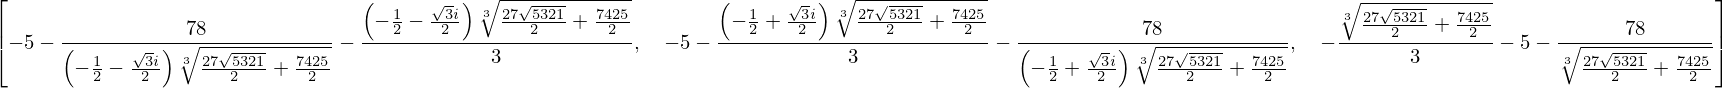

AttributeError: 'list' object has no attribute 'evalf'

In [126]:
x = sp.symbols('x')
ex = sp.Eq(x**3 + 15*x*x, 3*x - 10)
roots = sp.solve(ex,x)
display(roots)
roots.evalf()

#### Error:
```roots.evalf()``` should be 
```
roots[0].evalf()
roots[1].evalf()
roots[2].evalf()
```

#### Fix:
* Read the output.
* Python doesn't say "you forgot the [0]"
* Python is more literal. 
    * ```roots``` is a list and Python lists don't know anything about sympy's ```evalf``` function.
    * That is, you can't do ```list.evalf()```.
    * But that is a hint that you did it wrong. A hint that you need the [0], because the elements of the list are sympy expressions and ```some_expression.evalf()``` does make sense. 

## Example 3
Consider this problem and its solution. 


Solve the following two equations in the two unknowns $c_L$ and $c_{\eta}$:
$$\int_0^{\infty}E(\kappa)d\kappa = K,$$

$$\int_0^{\infty}2\nu\kappa^2E(\kappa)d\kappa = \epsilon.$$
Here, $\nu = 1.5\times 10^{-5}$, $K = 0.008$, and $\epsilon = 0.003$. 

You can take $\infty\approx 1E5$.

We also have the following functions and relations:
$$L = \frac{K^{3/2}}{\epsilon},$$
$$\eta = \left(\frac{\nu^3}{\epsilon}\right)^{1/4},$$

$$E(\kappa) = 1.5\epsilon^{2/3}\kappa^{-5/3}f_L(\kappa)f_{\eta}(\kappa),$$

$$f_L(\kappa) = \left(\frac{\kappa L}{[(\kappa L)^2 + c_L]^{1/2}}\right)^{11/3},$$

$$f_{\eta}(\kappa) = \exp(-5.2([(\kappa\eta)^4 + c_{\eta}^4]^{1/4}-c_{\eta})).$$

* Guesses: $c_L=5$, $c_{\eta}=0.5$.
* Note: $K$ is different than $\kappa$

In [127]:
def F(cLcη):
    cL = cLcη[0]
    cη = cLcη[1]
    
    ν = 1.5E-5
    K = 0.008
    ϵ = 0.003
    inf = 1E5
    
    L = K**1.5/ϵ
    η = (ν**3/ϵ)**0.25
    
    def fL(κ):
        return (κ*L/np.sqrt((κ*L)**2 + cL))**(11/3)
    
    def fη(κ):
        return np.exp(-5.2*(((κ*η)**4 + cη**4)**0.25) - cη)
    
    def E(κ):
        return 1.5*ϵ**(2/3)*κ**(-5/3)*fL(κ)*fη(κ)
    
    def twoNuK2E(κ):
        return 2*ν*κ*2*E(κ)
    
    eq0 = quad(E,        0, inf)    - K
    eq1 = quad(twoNuK2E, 0, inf)[0] - ϵ
    
    return np.array([eq0, eq1])

#-----------------------------------------------------------

guess = np.array([5, 0.5])

cLcη = fsolve(F, guess)

print(f'cL = {cLcη[0]:.4f}')
print(f'cη = {cLcη[1]:.4f}')

TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

#### Errors:

```eq0 = quad(E, 0, inf) - K``` should be 

```eq0 = quad(E, 0, inf)[0] - K```
    

#### Fix:
* Read the error message. 
    * Often just scroll to the bottom. Don't read the whole thing.
    * The line number is listed. Look there. 
    * Python doesn't say "you forgot the [0]. It is more literal. It says "you are trying to subtract a tuple and a float.
        * Look for the "-". The left side is a tuple (quad), the right is a float (a number, K). 
        * This is a big hint. You don't want a tuple you want the integral. Then we remember...

#### Error:

```return np.exp(-5.2*(((κ*η)**4 + cη**4)**0.25) - cη)``` should be

```return np.exp(-5.2*(((κ*η)**4 + cη**4)**0.25 - cη))```

#### Fix:
* Here we just see an invalid value encountered in sqrt.
    * This often means that we either
        * Typed the equations wrong
        * Gave bad guesses
        * (Got unlucky)
* We look carefully at the equation and fix our problem.

#### Error:

```return 2*ν*κ*2*E(κ)``` should be 

```return 2*ν*κ**2*E(κ)``` 

#### Fix:
* This is a really bad error. 
* The code runs fine. But we get the wrong answer.
* You have to use engineering intuition and other checks to find these bugs.
* The best thing is to be **very** careful with your work. Check it twice. 
* Invert the problem.
    * Once you have the solution, you can run it through the equations to see if you recover the desired answer.
        * This may or may not help. 
        * In the above case, it won't if we use the same twoNuK2E function to check, since that is where the bug is.
    * One test is to assume the answer (use the guesses), then compute K and ϵ, then work the problem and see if you recover your assumed answer. 
    * This is useful when it is easy to find K and ϵ if you know cL and cη, but hard to get cL and cη from K and ϵ.
* Sometimes it is worth starting over rather than tracking down a bug. You might not make the same typo again, and might actually save time.

## Other examples?

* Exceeding array bounds, or not being careful about indexing.
* Using ```^``` instead of ```**```
* Using ```6.02*10**23``` instead of 6.02E23 (more of a computational sin than a bug).
* Using conflicting names; like using ```f``` for both a function and a variable.
* Passing a function *call* as an argument instead of passing the function itself as the argument:
    * Like using this: ```I = quad(f(x), a, b)[0]``` 
    * instead of this: ```I = quad(f, a, b)[0]```
* Not being careful with units. Make sure everything is dimensionally consistent.